## 3- Models

Let's try to train some model to predict needs of clients. Here, we have to predict two target: *AccumulationInvestment* and *IncomeInvestment*. We chose, for each types of algorithms, to implement one model by target. As we have seen, we now have a dataset with 5 feature. This is not a lot so we can train complex model without to much cost and doing overfiting. 

To do so, we have choosen particularly two model : RF and ANN. 

The first one is because it is a ensemble of tree which is maximizing the prediction capacities. And manually, in this problem, we would have done a process of sorting data regarding some value : it's exactly a random forest. Thus, we found this model well fit and hop it will have good perfomance

The second is because of ANN could match up with whatever function we are searching. The need isn't writtable easily thus the objective function must be complicated (non linear for sur) so we expect that ANN will help us with this complexity.
  
To start, we import our previous data.

In [ ]:
# Tools'libraries
from sklearn.model_selection import train_test_split
from joblib import load

#Our Functions
from modelsFct import *

In [2]:
#Load our datas
%store -r X
%store -r t_inc
%store -r t_acc

In [3]:
#Create the subsets Train (80 %) and Test (20 %)
X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X, t_inc, t_acc, test_size=0.2, shuffle=True, random_state=5)

### Logistic models
  
The first models are the Logistic model. The principe of a Logistic regression is to classify observations into two class: "positive outcome" *C1* and "negative outcom" *C0*. For that, it compute the conditionned class probability.

It is a Supervised Learning technique for classification. As we said at the beginning, we do not expect a lot of these models but we will try to look for the best one.

To implement it, we looked for the best hyper-parameters models by using a python methods with a K-Cross validation (with 15 folds).

In [ ]:
logIncMod, logAccMod = getLogisticModel(X_train, Inc_train, Acc_train)

### Random Forest
  
Decision trees are a non-parametric supervised learning method. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (*sklearn.com*).  

Random Forest is an ensemble learning techniques. It uses severales decision trees to make a better prediction by aggregate all of the results of the trees. It is a bagging technique wich allows to reduce the variance of the model.  

For our problem, we will use **Classification trees** wich will give us binary output. The prediction of an input sample is a vote by the trees in the forest, weighted by their probability estimates.

As for the logistic regression, we look for the better hyper-parameters thanks to a K-cross-validation method (with 15 folds).

**Remarque:** Here, we do not run this code because it has a enorme computational costs (more than 8 minutes for a AMD Ryzen 8 cores). We store it and load it to use it. 

In [9]:
#Load the model
rfModInc = load('RandomForestInc.joblib')
rfModAcc = load('RandomForestAcc.joblib')

### Artificial Neural Networks

Artificial Neural Networks (ANNs) are powerful supervised machine learning algorithms. The algorithms learn the relationships between targets and features using a network of functions. Any continuous non-linear relationship can be approximated to arbitrary accuracy using an ANN.  

ANN is composed by multiples layers of neural: 1 *output layer* which is the prediction and *N hidden layer(s)* which are the neurons. In each layers, we have severals neurons that is an **activation function**.  

It is a complex non linear function really powerfull.

For our prediction, we choose to implement an simple ensemble neural network: Our model is composed by 3 neural networks where each one has a different numbers of neurons in the layer. Each one is train with a different subset of the trainig set. The prediction is simply an average of their prediction. It allows us to reduce the variance of our model.

In [ ]:
# IncomeInvesstisment model
nnIncMod = ensembleLearner(X_train, Inc_train, 120)

In [7]:
# AccumulationInvesstisment model
nnAccMod = ensembleLearner(X_train, Acc_train, 120)

### Model valuation

Let us see how the model perform with the test set in order to choose our final model for the two targets. 

We create a new metric, that we called **z-metric**, wich help us to score our model. Mathematically is equal to **0.6 * FN/TOTAL + 0.4 * FP/TOTAL**.  
*Explanation:* The metric is based on the misclassified prediction. We choose to penalize more the false negative prediction than the false positive because in a business point of view, it is more coherent. 

In [10]:
# IncomeInvesstisment prediction
predLogInc = logIncMod.predict(X_test)
predRFInc = rfModInc.predict(X_test)
predNnInc = predictionEnsemble(nnIncMod, X_test)

# AccumuulentInvt prediction
predLogAcc = logAccMod.predict(X_test)
predRFAcc = rfModAcc.predict(X_test)
predNnAcc = predictionEnsemble(nnAccMod, X_test)

#### Logistic Regression

Measures for IncomeInvestment:
Sensitivity = 55.56% ;  Specificity = 84.80% ; Precision = 65.52% ; F1 score = 60.13% ; Accuracy = 74.80% ; Zmetric = 13.12% 

Measures for AccumulationInvestment
Sensitivity = 61.49% ;  Specificity = 53.56% ; Precision = 57.86% ; F1 score = 59.62% ; Accuracy = 57.60% ; Zmetric = 20.88% 



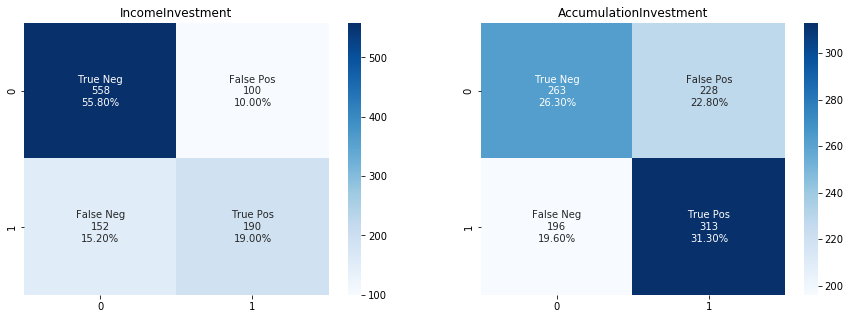

In [11]:
#Valuation of logistic models
confusionMat(predLogInc, predLogAcc, Inc_test, Acc_test)

For the logistic models, the result is not bad especially for the IncomeInvestment model. We can calibrate the parameters for see if we can significatvly improve the models.

#### Random Forest Classifier

Measures for IncomeInvestment:
Sensitivity = 62.87% ;  Specificity = 93.92% ; Precision = 84.31% ; F1 score = 72.03% ; Accuracy = 83.30% ; Zmetric = 9.22% 

Measures for AccumulationInvestment
Sensitivity = 73.87% ;  Specificity = 82.48% ; Precision = 81.39% ; F1 score = 77.45% ; Accuracy = 78.10% ; Zmetric = 11.42% 



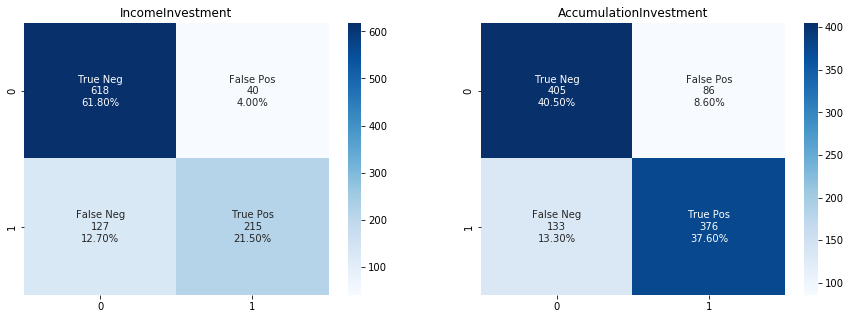

In [12]:
#Valuation of random Forest models
confusionMat(predRFInc, predRFAcc, Inc_test, Acc_test)

The results of the models are very good. The precision and accuracy are very hight. We can try to improve the models via the hyperparameters.

#### Artificial Neural Network

For the Artificial Neural Network model, we use a validation set in order to select the optimal threshold, wich minimize our z-metric, for the two models. We found that the optimal is equal to 0.33 for the IncomeInvesstisment target and 0.28 for the AccumulationInvesstisment target. The methodologie that we use is in the Annexe notebook.

Measures for IncomeInvestment:
Sensitivity = 65.50% ;  Specificity = 88.91% ; Precision = 75.42% ; F1 score = 70.11% ; Accuracy = 80.90% ; Zmetric = 10.00% 

Measures for AccumulationInvestment
Sensitivity = 74.85% ;  Specificity = 81.26% ; Precision = 80.55% ; F1 score = 77.60% ; Accuracy = 78.00% ; Zmetric = 11.36% 



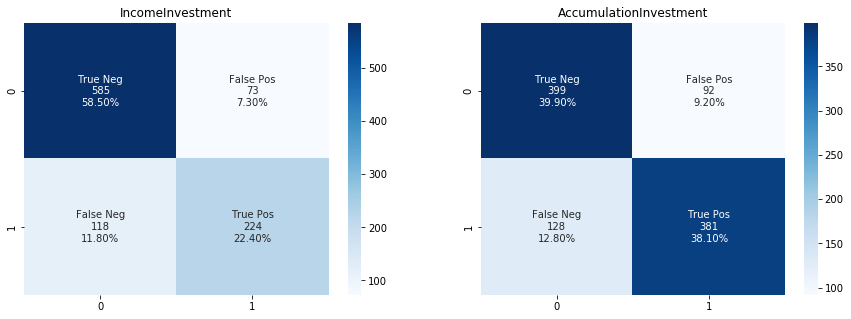

In [13]:
#Valuation of neural Networks models
iPred = (predNnInc > 0.33).astype(int)
aPred = (predNnAcc > 0.28).astype(int)

confusionMat(iPred, aPred, Inc_test, Acc_test)

Neural Networks model is fine for the IncomeInvestment model but for the AccumulationInvestment, is bad. We didn't exepct that so we can try to improve it. 

Finally, due to the good result, we choose to keep the random forest classifier for the IncomeInvesstisment target and the ensemble artificial neural network classifier for the AccumulationInvesstisment target.

Now, let try to explain the models with interpretability techniques.

In [ ]:
modIncome = rfModInc
modAccumulation = nnAccMod

#Store the model
%store modIncome
%store modAccumulation

#Store the sets
%store X_test
%store Inc_test
%store Acc_test